In [1]:
%matplotlib qt

In [2]:
import mne
from pprint import pprint
import json
import csv
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from pathlib import Path
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

In [37]:
# Use the .fif files produced from kit2fiff packages
root_data_path = Path("/Users/neuroling/Downloads/20250610_EEG-Demo")
print(root_data_path)

# new = new gel ; original: old gel

EEG_cntFile = root_data_path / Path('eeg_20250610_test_original_MMN_noNotch.cnt') #eeg_20250610_test_original_noNotch.cnt
#LDT_raw =  mne.io.read_raw_kit(LDT_confile, stim = [195], preload=True) #, slope = '+') #slope=將3個stim_channel的訊號全部加成,讓訊號增強
                                                                #把原始的KIT資料讀進
#LDT_raw.plot()
#events = mne.find_events(LDT_raw, stim_channel='STI 014') #將集合而成的channel命名為STI 014

MMN_raw = mne.io.read_raw_cnt(EEG_cntFile, eog="header", preload=True)
#MMN_raw.plot()

n_MMN_raw = MMN_raw.copy()
#n_MMN_filtered = n_MMN_raw.notch_filter(freqs=50, picks="all")
n_MMN_raw.plot()
#n_MMN_filtered.plot()
print(n_MMN_raw.info)

# Calculate the power spectrum density to examine the power in each frequency.
n_MMN_raw.compute_psd(fmin=1, fmax=100).plot()#.(fmax=100)

# Save the cnt into .fif for a easier further analysis
fif_DIR = root_data_path / 'rawfif_all'
fif_DIR.mkdir(exist_ok=True)

#n_MMN_raw.save(fif_DIR / Path('eeg_20250610_test_new_MMN_noNotch.fif'), overwrite=True)

/Users/neuroling/Downloads/20250610_EEG-Demo
Reading 0 ... 407295  =      0.000 ...   397.749 secs...
Using pyopengl with version 3.1.1a1
<Info | 10 non-empty values
 bads: 1 items (Trigger)
 ch_names: Fz_1, Trigger
 chs: 1 EOG, 1 EEG
 custom_ref_applied: False
 dig: 5 items (3 Cardinal, 2 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2025-10-06 07:34:08 UTC
 nchan: 2
 projs: []
 sfreq: 1024.0 Hz
 subject_info: 5 items (dict)
>
Effective window size : 2.000 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Channels marked as bad:
['Trigger']


In [53]:
n_MMN_raw.ch_names # Where are the annotations

['Fz_1', 'Trigger']

In [84]:
# This is the original brain data's triggers
'''
Triggers_ID:
12345 >> the start of task
55 >> the end of task
20 ~ 24 >> the start of questions' texts (irrelevant in here, please ignore it)
'''

## Segment the EEG according to tasks, 5 parts in total.
events_ann_ndArray = mne.events_from_annotations(n_MMN_raw)[0]
print(events_ann_ndArray)
print(type(events_ann_ndArray))
print(len(events_ann_ndArray))
print(mne.events_from_annotations(n_MMN_raw)[1], len(mne.events_from_annotations(n_MMN_raw)[1]))

events_id_DICT = {'1': 1, '2': 2, '20': 3, '21': 4, '22': 5, '23': 6, '24': 7, '3': 8, '4': 9, '5': 10, '55': 11}
raw_sfreq = n_MMN_raw.info['sfreq'] # supposedly to be 1000 Hz
fifname_LIST = ["eyeOpen_2min", "eyeClose_2min", "Blink_60count", "HEOG_60count", "VEOG_60count"]

# Get the start points in every 3 segment, staring from index[0]
start_tNDarray = events_ann_ndArray[::3]
print(start_tNDarray)
print(len(start_tNDarray))

# Get the end points in every 3 segment, staring from index[2]
end_tNDarray = events_ann_ndArray[2::3]
print(end_tNDarray)
print(len(end_tNDarray))

# segment the EEG data according to the points that are going to be converted into times, and save the raw EEG files
for i in range(5):
    print(start_tNDarray[i][0]/int(raw_sfreq), end_tNDarray[i][0]/int(raw_sfreq))
    # in here, we exclude the +0.5 at the end of the end points for the reason of 0.5 delay when the questions start trigger appear
    cut_eeg = n_MMN_raw.copy().crop((start_tNDarray[i][0]/int(raw_sfreq)), (end_tNDarray[i][0]/int(raw_sfreq)))
    cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_LIST[i]), overwrite=True)


"""
epochs = mne.Epochs(n_MMN_raw, events=events_ann_ndArray, event_id=events_id_DICT, preload=True)
                    tmin=, tmax=0.8, baseline=(None, 0), preload=True)
"""

Used Annotations descriptions: ['1', '2', '20', '21', '22', '23', '24', '3', '4', '5', '55']
[[  8744      0      1]
 [ 68651      0      3]
 [144131      0     11]
 [146165      0      2]
 [209144      0      4]
 [278897      0     11]
 [280916      0      8]
 [346966      0      5]
 [357762      0     11]
 [359970      0      9]
 [432166      0      6]
 [439272      0     11]
 [441476      0     10]
 [510597      0      7]
 [520315      0     11]]
<class 'numpy.ndarray'>
15
Used Annotations descriptions: ['1', '2', '20', '21', '22', '23', '24', '3', '4', '5', '55']
Used Annotations descriptions: ['1', '2', '20', '21', '22', '23', '24', '3', '4', '5', '55']
{'1': 1, '2': 2, '20': 3, '21': 4, '22': 5, '23': 6, '24': 7, '3': 8, '4': 9, '5': 10, '55': 11} 11
[[  8744      0      1]
 [146165      0      2]
 [280916      0      8]
 [359970      0      9]
 [441476      0     10]]
5
[[144131      0     11]
 [278897      0     11]
 [357762      0     11]
 [439272      0     11]
 [520315      

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/114270842.py:32: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eyeOpen_2min_new_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_LIST[i]), overwrite=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/114270842.py:32: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/eyeClose_2min_new_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_L

Closing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/HEOG_60count_new_Notched.fif
[done]
431.12890625 508.1201171875
Writing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/VEOG_60count_new_Notched.fif
Closing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/VEOG_60count_new_Notched.fif
[done]


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_27770/114270842.py:32: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/VEOG_60count_new_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_eeg.save(fif_DIR / Path('%s_new_Notched.fif' %fifname_LIST[i]), overwrite=True)


'\nepochs = mne.Epochs(n_MMN_raw, events=events_ann_ndArray, event_id=events_id_DICT, preload=True)\n                    tmin=, tmax=0.8, baseline=(None, 0), preload=True)\n'

In [55]:
# Merged 2 part of MMNs
uncut_fif_DIR = fif_DIR / 'Uncut_rawfif'
MMN_noNotch_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('eeg_20250610_test_original_MMN_noNotch.fif'), preload=True)
MMN_Notched_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('eeg_20250610_test_original_MMN_Notched.fif'), preload=True)

MMN_LIST = [MMN_noNotch_fif, MMN_Notched_fif]
#MMN_merged_LIST = mne.concatenate_epochs(MMN_LIST)
raw_MMN_fif = mne.concatenate_raws(MMN_LIST)

raw_MMN_fif = mne.io.read_raw_fif(rawfif_datapath, preload=True)
# Check whether the ch exists
print(raw_MMN_fif.info['ch_names'])
print(raw_MMN_fif.get_channel_types())
# Rename the channels
raw_MMN_fif.rename_channels({'Fz_1': 'Fz_1'})
raw_MMN_fif.set_channel_types({'Fz_1': 'eeg'})
raw_MMN_fif.plot()
MMN_eventsArray = mne.events_from_annotations(raw_MMN_fif)[0]
print(len(MMN_eventsArray[0]), MMN_eventsArray)

raw_MMN_fif.save(uncut_fif_DIR / Path('test_orig_MMN_merged_raw.fif'), overwrite=True)
raw_MMN_fif
print(raw_MMN_fif.info)

Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_original_MMN_noNotch.fif...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_16801/255016129.py:3: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_original_MMN_noNotch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  MMN_noNotch_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('eeg_20250610_test_original_MMN_noNotch.fif'), preload=True)


    Range : 0 ... 407295 =      0.000 ...   397.749 secs
Ready.
Reading 0 ... 407295  =      0.000 ...   397.749 secs...
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_original_MMN_Notched.fif...
    Range : 0 ... 410623 =      0.000 ...   400.999 secs
Ready.
Reading 0 ... 410623  =      0.000 ...   400.999 secs...
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_new_MMN_noNotch.fif...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_16801/255016129.py:4: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_original_MMN_Notched.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  MMN_Notched_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('eeg_20250610_test_original_MMN_Notched.fif'), preload=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_16801/255016129.py:10: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_new_MMN_noNotch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.f

    Range : 0 ... 410367 =      0.000 ...   400.749 secs
Ready.
Reading 0 ... 410367  =      0.000 ...   400.749 secs...
['Fz_1', 'Trigger']
['eog', 'eeg']
Using pyopengl with version 3.1.1a1
Used Annotations descriptions: ['1', '2', '3', '4']
3 [[  4908      0      4]
 [  5676      0      4]
 [  6444      0      4]
 ...
 [401278      0      1]
 [402046      0      1]
 [402814      0      3]]
Writing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/test_orig_MMN_merged_raw.fif
Closing /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/test_orig_MMN_merged_raw.fif
[done]
<Info | 12 non-empty values
 bads: 1 items (Trigger)
 ch_names: Fz_1, Trigger
 chs: 2 EEG
 custom_ref_applied: False
 dig: 5 items (3 Cardinal, 2 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2025-10-06 06:35:17 UTC
 meas_id: 4 items (dict)
 nchan: 2
 projs: []
 sfreq: 1024.0 Hz
 subject_info: 2 items (dict)
>
Channels marked as bad:
['Trigger']


Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/test_orig_MMN_merged_raw.fif...
    Range : 0 ... 410367 =      0.000 ...   400.749 secs
Ready.
Reading 0 ... 410367  =      0.000 ...   400.749 secs...
Effective window size : 2.000 (s)


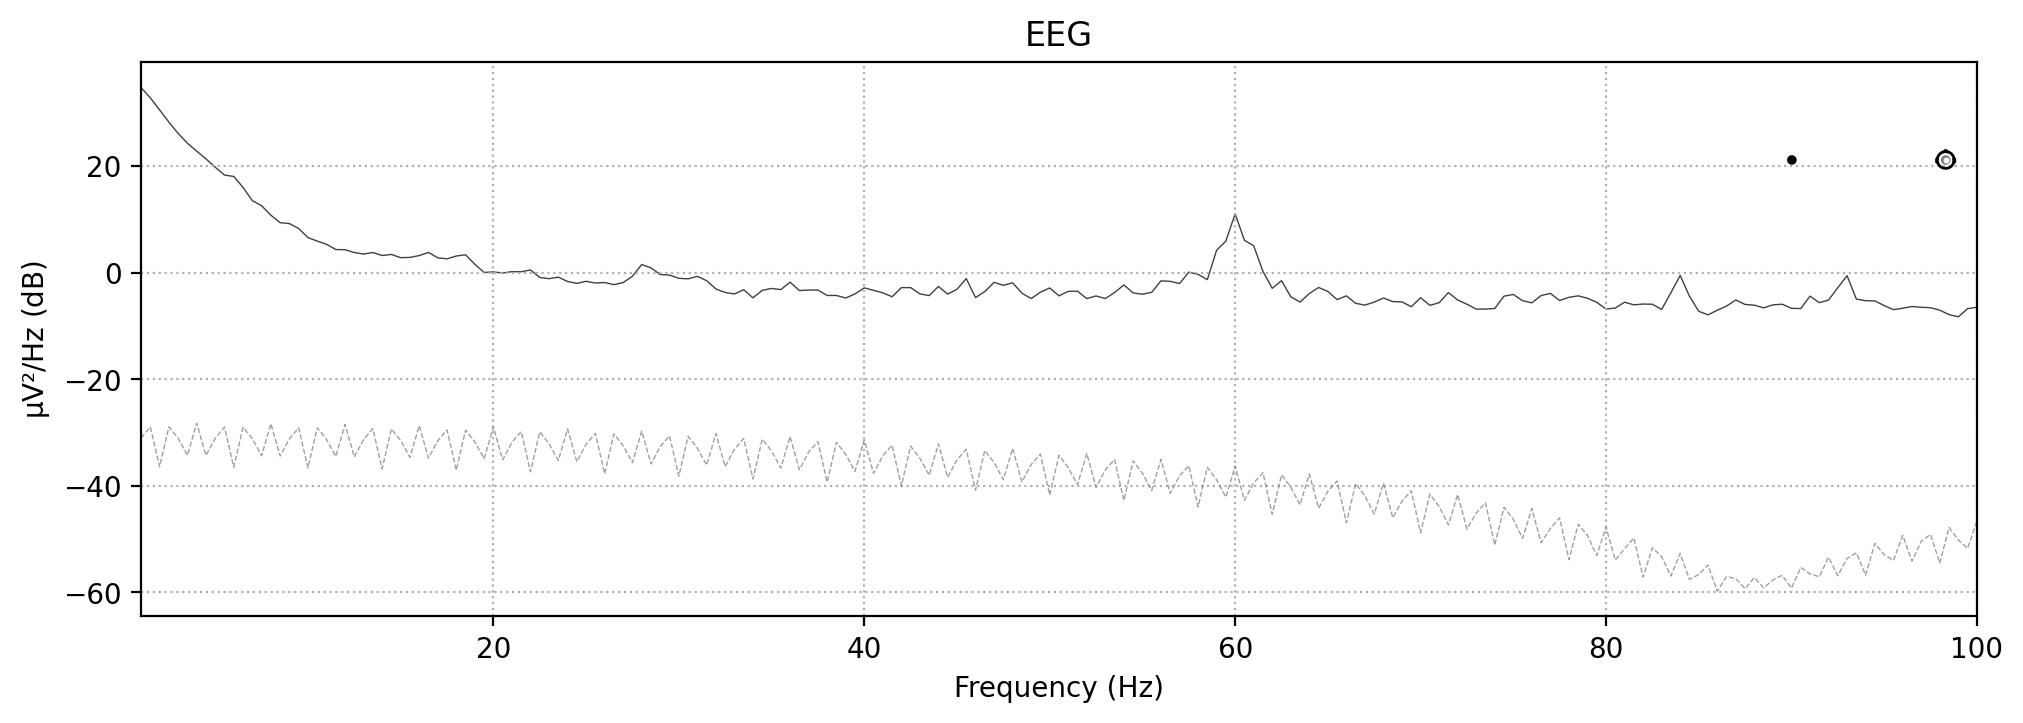

In [56]:
N_orig_MMN_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('test_orig_MMN_merged_raw.fif'), preload=True)
N_orig_MMN_merged_fif.compute_psd(fmin=1, fmax=100).plot()

Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/orig_MMN_merged_raw.fif...
    Range : 0 ... 817919 =      0.000 ...   798.749 secs
Ready.
Reading 0 ... 817919  =      0.000 ...   798.749 secs...
Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/new_MMN_merged_raw.fif...
    Range : 0 ... 825599 =      0.000 ...   806.249 secs
Ready.
Reading 0 ... 825599  =      0.000 ...   806.249 secs...
Effective window size : 2.000 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Effective window size : 2.000 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


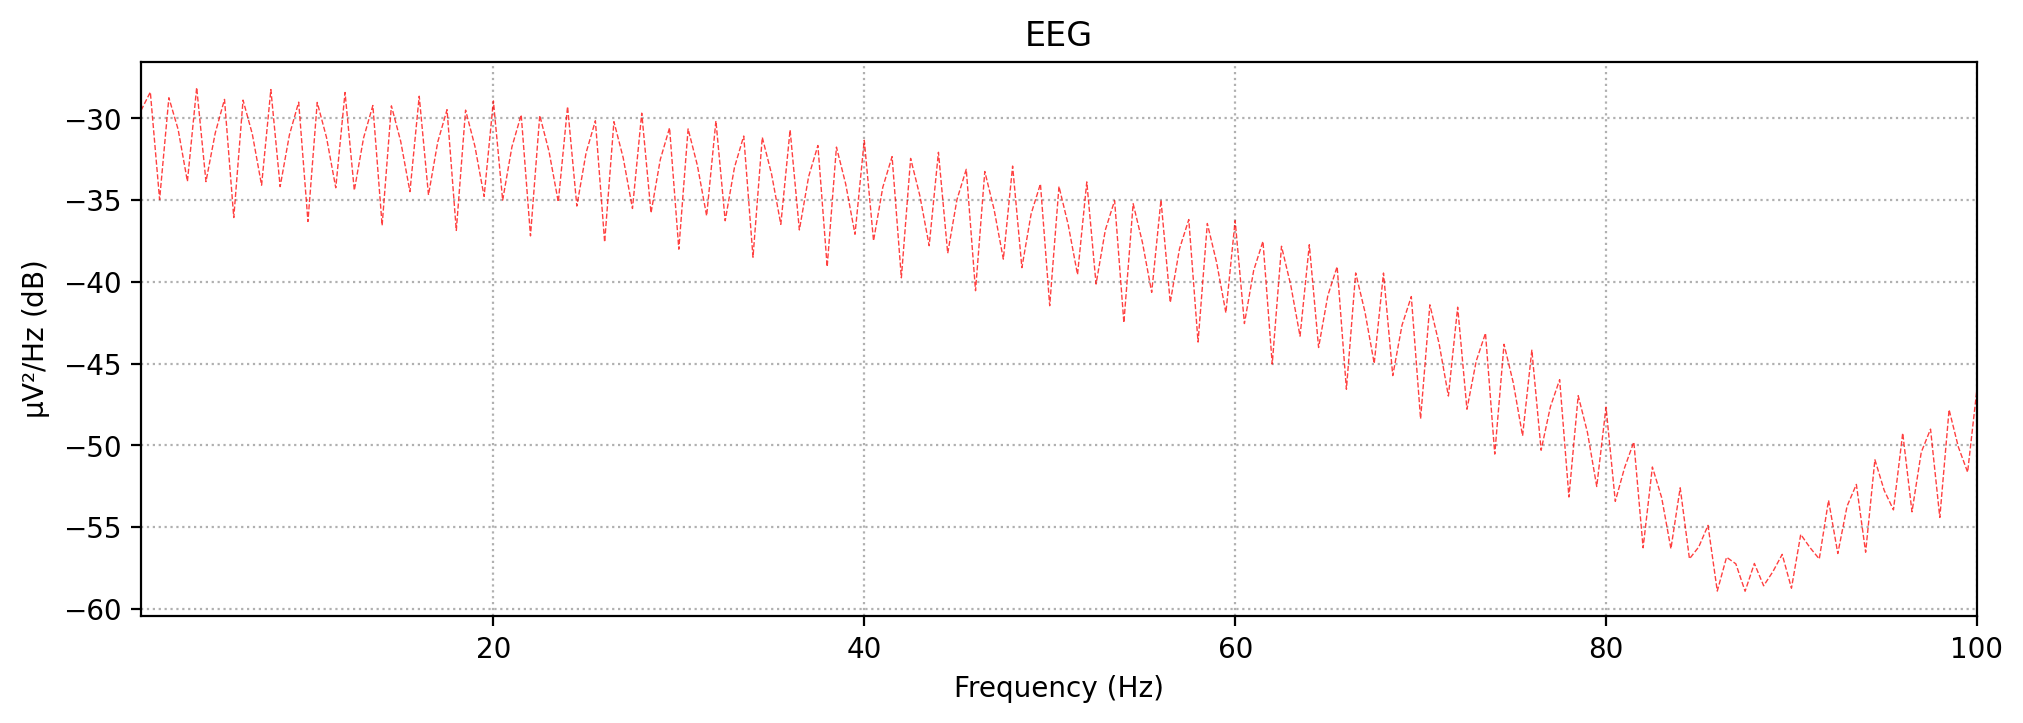

In [54]:
# Compute the psd of two different kinds of gel
orig_MMN_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('orig_MMN_merged_raw.fif'), preload=True)
new_MMN_merged_fif = mne.io.read_raw_fif(uncut_fif_DIR / Path('new_MMN_merged_raw.fif'), preload=True)

orig_MMN_merged_fif.compute_psd(fmin=1, fmax=100).plot()
new_MMN_merged_fif.compute_psd(fmin=1, fmax=100).plot()

Effective window size : 2.000 (s)


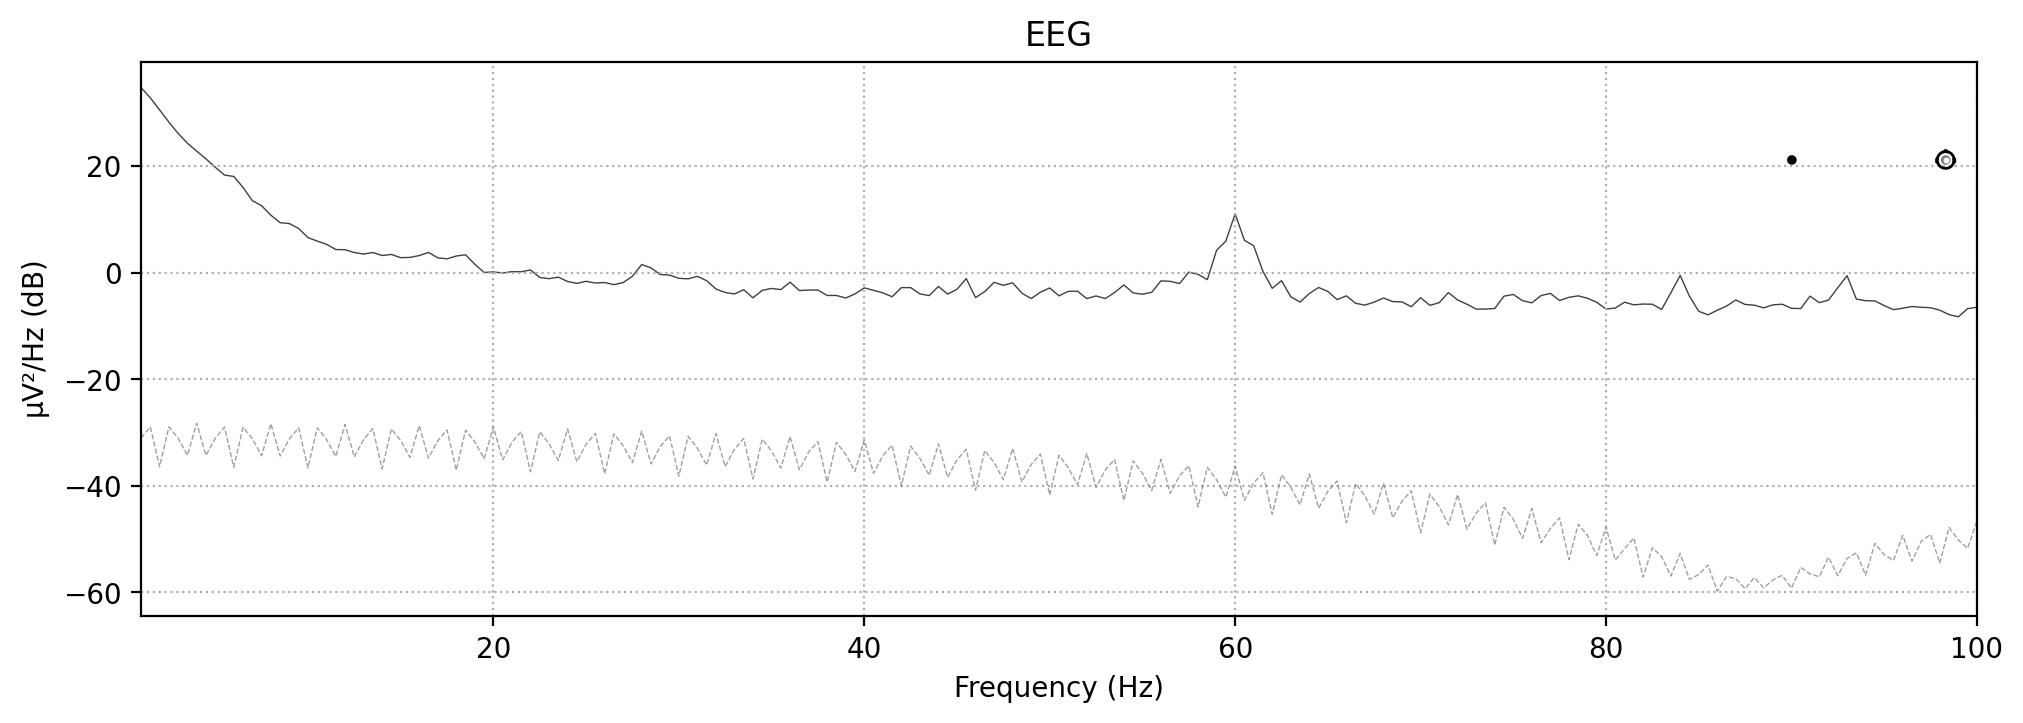

2025-08-22 18:03:51.157 python[16801:20845248] +[CATransaction synchronize] called within transaction
2025-08-22 18:03:55.698 python[16801:20845248] +[CATransaction synchronize] called within transaction
2025-08-22 18:03:57.323 python[16801:20845248] +[CATransaction synchronize] called within transaction
2025-08-22 18:03:57.590 python[16801:20845248] +[CATransaction synchronize] called within transaction


In [47]:
raw_MMN_fif.compute_psd(fmin=1, fmax=100).plot()


In [46]:
# MMN data analysis
uncut_fif_DIR = fif_DIR / 'Uncut_rawfif'
rawfif_datapath = uncut_fif_DIR / Path('eeg_20250610_test_new_MMN_noNotch.fif')

raw_MMN_fif = mne.io.read_raw_fif(rawfif_datapath, preload=True)
# Check whether the ch exists
print(raw_MMN_fif.info['ch_names'])
print(raw_MMN_fif.get_channel_types())
# Rename the channels
raw_MMN_fif.rename_channels({'Fz_1': 'Fz_1'})
raw_MMN_fif.set_channel_types({'Fz_1': 'eeg'})

raw_MMN_fif.plot()
MMN_eventsArray = mne.events_from_annotations(raw_MMN_fif)[0]
print(len(MMN_eventsArray[0]), MMN_eventsArray)


# Creating the new epochs
MMN_events = MMN_eventsArray#mne.find_events(raw_ICAed, stim_channel='STI 014')  #just checking what stim_channel documenting what.
MMN_event_id = {'standard':1,'deviant_2':2, 'deviant_3': 3}  

tmin = -0.1         								# pre stimulis interval (in seconds) #
tmax = 0.7          								# post stimulus interval #

baseline = (None, 0)  # tmin ~ 0 , -0.1s-0s   
#reject = dict(mag=4e-12)

# Load in the channels layouts
#kit_lay = mne.channels.read_layout("KIT-157")

epoch_DIR = fif_DIR / 'MMN_epochs'
#raw_MMN_fif.filter(0, 30, phase= 'zero-double').resample(500)
#raw_MMN_fif.resample(500)
#raw_MMN_fif.notch_filter(freqs=60)
n_epoch_MMN = mne.Epochs(raw_MMN_fif, MMN_events, MMN_event_id, tmin, tmax, baseline=baseline, preload = True)
print(n_epoch_MMN.info)
#n_epoch_MMN.save(epoch_DIR / Path('orig_MMN_noNotch_notchedFilter_epochs.fif'), overwrite=True)
n_epoch_MMN

Opening raw data file /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_new_MMN_noNotch.fif...
    Range : 0 ... 410367 =      0.000 ...   400.749 secs
Ready.
Reading 0 ... 410367  =      0.000 ...   400.749 secs...
['Fz_1', 'Trigger']
['eog', 'eeg']


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_16801/4236138308.py:5: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/Uncut_rawfif/eeg_20250610_test_new_MMN_noNotch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_MMN_fif = mne.io.read_raw_fif(rawfif_datapath, preload=True)


Using pyopengl with version 3.1.1a1
Used Annotations descriptions: ['1', '2', '3', '4']
3 [[  4908      0      4]
 [  5676      0      4]
 [  6444      0      4]
 ...
 [401278      0      1]
 [402046      0      1]
 [402814      0      3]]
Not setting metadata
500 matching events found
Setting baseline interval to [-0.099609375, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 500 events and 820 original time points ...
0 bad epochs dropped
<Info | 12 non-empty values
 bads: 1 items (Trigger)
 ch_names: Fz_1, Trigger
 chs: 2 EEG
 custom_ref_applied: False
 dig: 5 items (3 Cardinal, 2 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2025-10-06 06:35:17 UTC
 meas_id: 4 items (dict)
 nchan: 2
 projs: []
 sfreq: 1024.0 Hz
 subject_info: 2 items (dict)
>


Number of events,500
Events,deviant_2: 50deviant_3: 50standard: 400
Time range,-0.100 – 0.700 s
Baseline,-0.100 – 0.000 s


Channels marked as bad:
['Trigger']


In [ ]:
MMN_eventsArray = mne.events_from_annotations(raw_MMN_fif)[0]
print(len(MMN_eventsArray[0]), MMN_eventsArray)


# Creating the new epochs
MMN_events = MMN_eventsArray#mne.find_events(raw_ICAed, stim_channel='STI 014')  #just checking what stim_channel documenting what.
MMN_event_id = {'standard':1,'deviant_2':2, 'deviant_3': 3}  

tmin = -0.1         								# pre stimulis interval (in seconds) #
tmax = 0.7          								# post stimulus interval #

baseline = (None, 0)  # tmin ~ 0 , -0.1s-0s   
#reject = dict(mag=4e-12)

# Load in the channels layouts
#kit_lay = mne.channels.read_layout("KIT-157")

epoch_DIR = fif_DIR / 'MMN_epochs'
#raw_MMN_fif.filter(0, 30, phase= 'zero-double').resample(500)
#raw_MMN_fif.resample(500)
#raw_MMN_fif.notch_filter(freqs=60)
n_epoch_MMN = mne.Epochs(raw_MMN_fif, MMN_events, MMN_event_id, tmin, tmax, baseline=baseline, preload = True)
print(n_epoch_MMN.info)
#n_epoch_MMN.save(epoch_DIR / Path('orig_MMN_noNotch_notchedFilter_epochs.fif'), overwrite=True)
n_epoch_MMN

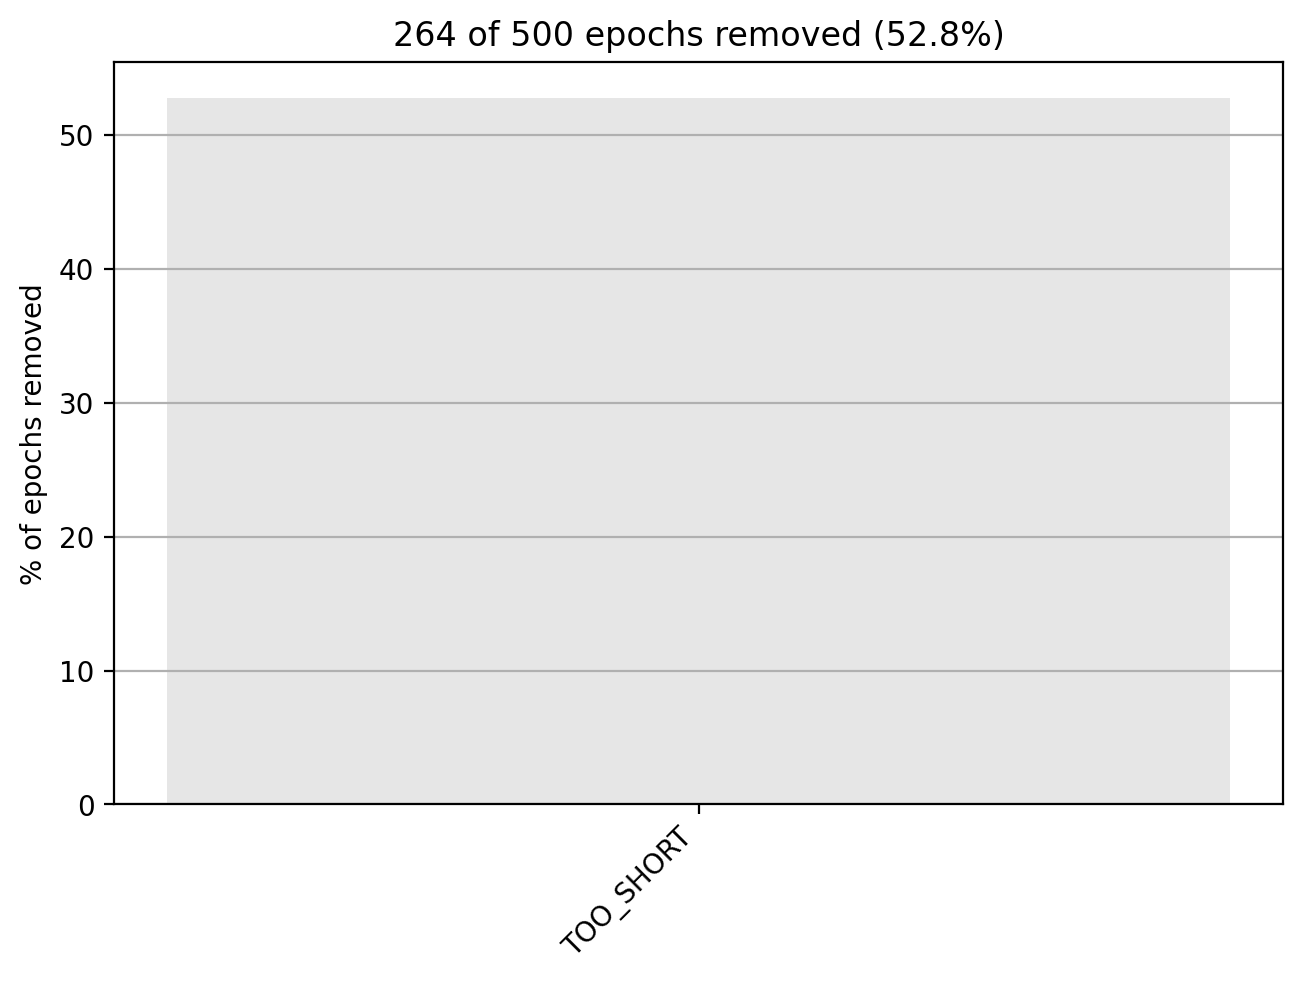

In [29]:
n_epoch_MMN.plot_drop_log()

In [91]:
MMN_noNotch_fif = mne.read_epochs(fif_DIR / Path('new_MMN_noNotch_epochs.fif'), preload=True)
print(MMN_noNotch_fif.info)
MMN_Notched_fif = mne.read_epochs(fif_DIR / Path('new_MMN_Notched_epochs.fif'), preload=True)
print(MMN_Notched_fif.info)

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/new_MMN_noNotch_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
236 matching events found
No baseline correction applied
0 projection items activated
<Info | 12 non-empty values
 bads: 1 items (Trigger)
 ch_names: Fz_1, Trigger
 chs: 2 EEG
 custom_ref_applied: False
 dig: 5 items (3 Cardinal, 2 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2025-10-06 06:35:17 UTC
 meas_id: 4 items (dict)
 nchan: 2
 projs: []
 sfreq: 500.0 Hz
 subject_info: 2 items (dict)
>
Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/new_MMN_Notched_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
233 matching events found
No baseline correction applied
0 projection items activated
<Info | 12 non-

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_10803/1717620363.py:1: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/new_MMN_noNotch_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  MMN_noNotch_fif = mne.read_epochs(fif_DIR / Path('new_MMN_noNotch_epochs.fif'), preload=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_10803/1717620363.py:3: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/new_MMN_Notched_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  MMN_Notched_fif = mne.read_epochs(fif_DIR / Path('new_MMN_Notched_epochs.fif'), preload=True)


In [87]:
# Merged 2 part of MMNs
MMN_noNotch_fif = mne.read_epochs(fif_DIR / Path('original_MMN_noNotch_epochs.fif'), preload=True)
MMN_Notched_fif = mne.read_epochs(fif_DIR / Path('original_MMN_Notched_epochs.fif'), preload=True)
MMN_LIST = [MMN_noNotch_fif, MMN_Notched_fif]
MMN_merged_epochLIST = mne.concatenate_epochs(MMN_LIST)
MMN_merged_epochLIST.save(fif_DIR / Path('original_MMN_merged_epochs.fif'), overwrite=True)
MMN_merged_epochLIST

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/original_MMN_noNotch_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
234 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/original_MMN_Notched_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
236 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
470 matching events found
Applying baseline correction (mode: mean)
Overwriting existing file.
Overwriting existing file.


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_10803/3260114243.py:2: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/original_MMN_noNotch_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  MMN_noNotch_fif = mne.read_epochs(fif_DIR / Path('original_MMN_noNotch_epochs.fif'), preload=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_10803/3260114243.py:3: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/original_MMN_Notched_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  MMN_Notched_fif = mne.read_epochs(fif_DIR / Path('original_MMN_Notched_epochs.fif'), preload=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_10803/3260114243.py:5: RuntimeWarning: Concatenation of Annotations within Epochs is no

<Info | 12 non-empty values
 bads: 1 items (Trigger)
 ch_names: Fz_1, Trigger
 chs: 2 EEG
 custom_ref_applied: False
 dig: 5 items (3 Cardinal, 2 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2025-10-06 07:34:08 UTC
 meas_id: 4 items (dict)
 nchan: 2
 projs: []
 sfreq: 500.0 Hz
 subject_info: 2 items (dict)
>

In [84]:
#MMN_merged_epochLIST.compute_psd(fmin=1, fmax=100).plot()
#evk_spectrum.plot(picks="data", exclude="bads")

epo_spectrum = MMN_merged_epochLIST.compute_psd()
psds, freqs = epo_spectrum.get_data(return_freqs=True)
print(f"\nPSDs shape: {psds.shape}, freqs shape: {freqs.shape}")
epo_spectrum

    Using multitaper spectrum estimation with 7 DPSS windows

PSDs shape: (470, 1, 201), freqs shape: (201,)


Data type,Power Spectrum
Units,eeg: V²/Hz
Data source,Epochs
Number of epochs,470
Dims,"epoch, channel, freq"
Estimation method,multitaper
Number of channels,2
Number of frequency bins,201
Frequency range,0.00 – 249.38 Hz


In [80]:
# Recalculate the merged MMN's evoked
# epochs to evoked
evoked_standard = MMN_mergedLIST['standard'].average()
evoked_deviant_2 = MMN_mergedLIST['deviant_2'].average()
evoked_deviant_3 = MMN_mergedLIST['deviant_3'].average()

# Plot mmn differences
tmp = [evoked_standard, evoked_deviant_2, evoked_deviant_3]
colors = 'red', 'blue', 'green'
#mne.viz.plot_evoked_topo(tmp, color = colors, title = 'MMN', ylim = dict(eeg=[10, -10]))
mmn_fig = mne.viz.plot_compare_evokeds(tmp, colors = colors) #, axes = 'topo')
#mmn_plot

"""
# Save fig
fig_DIR = root_data_path / 'MMN_figs'
fig_DIR.mkdir(exist_ok=True)
mmn_fig.save(fig_DIR / Path('original_noNotch_evoked_Fz_1.png'))#, overwrite=True)
"""
#plt.savefig(meg_data_path / Path('H-minus-L_evoked_topomap.png'), overwrite=True). # Check this later

"\n# Save fig\nfig_DIR = root_data_path / 'MMN_figs'\nfig_DIR.mkdir(exist_ok=True)\nmmn_fig.save(fig_DIR / Path('original_noNotch_evoked_Fz_1.png'))#, overwrite=True)\n"

In [82]:
evoked_standard_spectrum = evoked_standard.compute_psd()
print(evoked_standard_spectrum[:, :3])

    Using multitaper spectrum estimation with 7 DPSS windows
[[1.65686307e-10 3.19306986e-10 2.95409717e-10]
 [1.00448963e-16 2.22225178e-16 1.54311472e-16]]


In [67]:
# Use Amplitude-Based Heuristics

new_MMN_merged_fif = mne.read_epochs(fif_DIR / Path('new_MMN_merged_epochs.fif'), preload=True)
orig_MMN_merged_fif = mne.read_epochs(fif_DIR / Path('original_MMN_merged_epochs.fif'), preload=True)
new_data = new_MMN_merged_fif.get_data(picks='Fz_1')[0]  # assuming Fz_1 is your only channel
orig_data = orig_MMN_merged_fif.get_data(picks='Fz_1')[0]  # assuming Fz_1 is your only channel

new_peak_to_peak = new_data.max() - new_data.min()
orig_peak_to_peak = orig_data.max() - orig_data.min()

print(f"New Peak-to-peak amplitude: {new_peak_to_peak*1e6:.2f} µV")
print(f"Orignal Peak-to-peak amplitude: {orig_peak_to_peak*1e6:.2f} µV")


# Compute Variance or SNR as Proxy for Conductivity
epochs = mne.Epochs(raw, events, event_id, tmin=-0.1, tmax=0.8, preload=True)
data = epochs.get_data(picks='Fz_1')
variances = data.var(axis=2).flatten()
print(f"Variance across trials: {variances.mean():.2e} µV²")

Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/new_MMN_merged_epochs.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
469 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/original_MMN_merged_epochs.fif ...


/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_10803/2211969263.py:1: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/new_MMN_merged_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  new_MMN_merged_fif = mne.read_epochs(fif_DIR / Path('new_MMN_merged_epochs.fif'), preload=True)
/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_10803/2211969263.py:2: RuntimeWarning: This filename (/Users/neuroling/Downloads/20250610_EEG-Demo/rawfif_all/original_MMN_merged_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  orig_MMN_merged_fif = mne.read_epochs(fif_DIR / Path('original_MMN_merged_epochs.fif'), preload=True)


    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
470 matching events found
No baseline correction applied
0 projection items activated
New Peak-to-peak amplitude: 39.34 µV
Orignal Peak-to-peak amplitude: 39.47 µV


In [72]:
# Assume you already have epochs
data = orig_MMN_merged_fif.get_data(picks='Fz_1')  # shape: (n_trials, 1, n_times)

# Compute signal (mean) and noise (std) across trials
erp = data.mean(axis=0)[0]    # shape: (n_times,)
noise = data.std(axis=0)[0]   # shape: (n_times,)

# Instantaneous SNR over time
snr = erp / noise

# Average SNR in a specific window (e.g., MMN: 100–250 ms)
times = orig_MMN_merged_fif.times
mask = (times >= 0.0) & (times <= 0.7)
snr_avg = snr[mask].mean()

print(f"ERP-based SNR at Fz_1 (100–700 ms): {snr_avg:.2f}")


ERP-based SNR at Fz_1 (100–700 ms): -0.01


In [74]:
psd = orig_MMN_merged_fif.compute_psd(fmin=1, fmax=30, picks='Fz_1')
freqs = psd.freqs
power = psd.get_data()[0]  # shape: (n_freqs,)

# Define frequency bands
signal_band = (freqs >= 8) & (freqs <= 12)     # alpha band
noise_band = ((freqs >= 5) & (freqs < 8)) | ((freqs > 12) & (freqs <= 15))

# Compute power
signal_power = power[signal_band].mean()
noise_power = power[noise_band].mean()

snr_db = 10 * np.log10(signal_power / noise_power)
print(f"Spectral SNR (alpha vs sidebands) at Fz_1: {snr_db:.2f} dB")

    Using multitaper spectrum estimation with 7 DPSS windows


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 24

In [38]:
# Compute MMN's psd
psd = raw_MMN_fif.compute_psd(fmin=1, fmax=100).plot()
#psd_data = psd.get_data()

n_rejected = len(n_epoch_MMN.drop_log)
n_total = len(MMN_events)
noise_percent = (n_rejected / n_total) * 100
print(f"{noise_percent:.1f}% of epochs rejected due to noise")

Effective window size : 2.000 (s)
100.0% of epochs rejected due to noise


In [47]:
# epochs to evoked
evoked_standard = n_epoch_MMN['standard'].average()
evoked_deviant_2 = n_epoch_MMN['deviant_2'].average()
evoked_deviant_3 = n_epoch_MMN['deviant_3'].average()

# Plot mmn differences
tmp = [evoked_standard, evoked_deviant_2, evoked_deviant_3]
colors = 'red', 'blue', 'green'
#mne.viz.plot_evoked_topo(tmp, color = colors, title = 'MMN', ylim = dict(eeg=[10, -10]))
mmn_fig = mne.viz.plot_compare_evokeds(tmp, colors = colors) #, axes = 'topo')
#mmn_plot

"""
# Save fig
fig_DIR = root_data_path / 'MMN_figs'
fig_DIR.mkdir(exist_ok=True)
mmn_fig.save(fig_DIR / Path('original_noNotch_evoked_Fz_1.png'))#, overwrite=True)
"""
#plt.savefig(meg_data_path / Path('H-minus-L_evoked_topomap.png'), overwrite=True). # Check this later

"\n# Save fig\nfig_DIR = root_data_path / 'MMN_figs'\nfig_DIR.mkdir(exist_ok=True)\nmmn_fig.save(fig_DIR / Path('original_noNotch_evoked_Fz_1.png'))#, overwrite=True)\n"

2025-08-22 14:00:37.085 python[10803:20716774] +[CATransaction synchronize] called within transaction


In [24]:
# get to know the reason of bad epoch drop
print(epoch_LDT.drop_log)

((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('MEG 117',), (), ())
